In [2]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 MB 9.0 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 8.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 7.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.8/370.8 kB 7.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.1 MB/s eta 0:00:0000:0100:01
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:0

In [3]:
import numpy as np
import pandas as pd
import torch
import math
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, MLP, Informer, FEDformer,StemGNN,NBEATSx
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA,MSTL
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import AutoNHITS
import matplotlib.pyplot as plt
from neuralforecast.losses.pytorch import HuberLoss
from ray import tune
from datetime import datetime
from datetime import date, timedelta

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-29 23:30:25,036	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-29 23:30:25,296	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
delta = pd.read_csv('data/DAL_data.csv')
oil = pd.read_csv('data/CLF_data.csv')


In [9]:
def time_data_to_nixtla_data(df):
    df = df.copy()
    df.reset_index()
    df = df.rename(columns={"Adj Close":"y"})
    #Unique_id is to identify which time series we are in
    df['unique_id'] = 1
    df['ds'] = pd.to_datetime(delta['Date']).dt.date
    df = df[['y', 'ds', 'unique_id']]
    return df

# Train test split
def split_data(data,train_percent):
    if type(data) == torch.Tensor:
        return data[:math.floor(train_percent*data.shape[0]),:],data[math.floor(train_percent*data.shape[0]):,:]
        
    else:
        return data.iloc[:math.floor(train_percent*data.shape[0])],data.iloc[math.floor(train_percent*data.shape[0]):]

    
df = time_data_to_nixtla_data(delta)
df[df.isnull()] = 0
train,test = split_data(df,0.9)

In [16]:
train['ds'] = pd.to_datetime(train['ds'])

In [25]:
train

,y,ds,unique_id
0,29.590050,2014-03-24,1
1,30.575798,2014-03-25,1
2,30.158407,2014-03-26,1
3,30.309376,2014-03-27,1
4,29.776543,2014-03-28,1
...,...,...,...
2261,33.465816,2023-03-16,1
2262,32.721252,2023-03-17,1
2263,32.899944,2023-03-20,1
2264,33.644512,2023-03-21,1


In [40]:
horizon = 5
h = horizon
input_size = 10*horizon

In [41]:
models = [
    # AutoNHITS(h=horizon,
    #               loss=HuberLoss(),
    #               config=nhits_config,
    #               search_alg=HyperOptSearch(),
    #               backend='ray',
    #               num_samples=50 #TODO in practice should be much bigger than 10
    #          )
    #  StemGNN(h=horizon,
    #         input_size=input_size,
    #         n_series=1,
    #         futr_exog_list=futr_exog,
    # # include weekday when doing daily_data
    #         hist_exog_list=hist_exog,
    #         scaler_type='robust',
    #         max_steps=100,
    #         early_stop_patience_steps=-1,
    #         val_check_steps=10,
    #         learning_rate=1e-3,
    #         loss=MAE(),
    #         valid_loss=None,
    #         batch_size=32
    #         ),
    NBEATSx(h=h, input_size=input_size,
                #loss=MQLoss(level=[80, 90]),
                loss=MAE(),
                scaler_type='robust',
                dropout_prob_theta=0.5,
                max_steps=200,
                val_check_steps=10,
                early_stop_patience_steps=2),
    # MLP(h=h, input_size=input_size,
    #         loss=MAE(),
    #         scaler_type='robust',
    #         learning_rate=1e-3,
    #         max_steps=200,
    #         val_check_steps=10,
    #         early_stop_patience_steps=2),
    NHITS(
        h=horizon,
        input_size=input_size,
        loss=HuberLoss(),
        n_freq_downsample=[168,24,1],
        max_steps=200,
        scaler_type = 'robust',
        val_check_steps=10,
                early_stop_patience_steps=2
    ),
     # Informer(h=horizon,
     #             input_size=input_size,
     #             hidden_size=64,
     #             conv_hidden_size=128,
     #             n_head=8,
     #             loss=MAE(),
     #             futr_exog_list=futr_exog,
     #             scaler_type='robust',
     #             learning_rate=1e-3,
     #             max_steps=200,
     #             batch_size=2,
     #             windows_batch_size=32,
     #             val_check_steps=50,
     #             early_stop_patience_steps=2),
     # FEDformer(h=horizon,
     #             input_size=input_size,
     #             modes=64,
     #             hidden_size=64,
     #             conv_hidden_size=128,
     #             n_head=8,
     #             loss=MAE(),
     #             futr_exog_list=futr_exog,
     #             scaler_type='robust',
     #             learning_rate=1e-3,
     #             max_steps=200,
     #             batch_size=2,
     #             windows_batch_size=32,
     #             val_check_steps=50,
     #             early_stop_patience_steps=2),
    
]

Seed set to 1
Seed set to 1


In [42]:
nf = NeuralForecast(models=models, freq='D')
# nf.fit(df=train,val_size=input_size)
cv_df = nf.cross_validation(train, n_windows=2)

Epoch 9: 100%|█| 1/1 [00:00<00:00, 12.20it/s, v_num=10, train_loss_step=0.946, t
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 1/1 [00:00<00:00, 216.46it/s]

RuntimeError: Early stopping conditioned on metric `ptl/val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`, `train_loss_step`, `train_loss_epoch`

In [43]:
predict = nf.predict()
predict

Exception: You must fit the model before predicting.

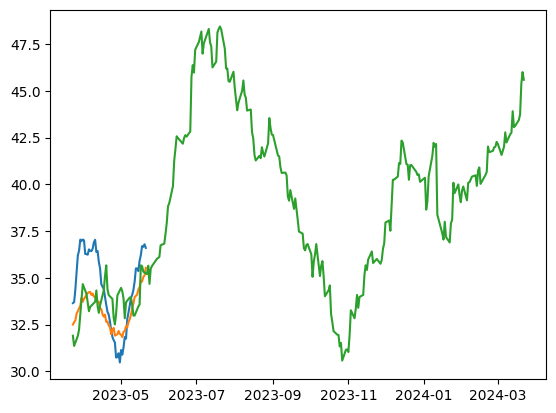

In [32]:
plt.plot(predict['ds'], predict['NHITS'])
plt.plot(predict['ds'], predict['NBEATSx'])
plt.plot(test['ds'], test['y'])